# 3D MHD simulation with Volume penalization method
This notebook aims to show the workflow of setting up a 3D MHD simulation with Volume penalization method in the cylindrical coordinates. ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X))

We pick the set up of magnetohydrodynamic Taylor-Couette flow (example 5.4) from ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X)) as a showcase. The result would be slightly different from the  ([Morales et al. 2012](https://www.sciencedirect.com/science/article/pii/S002199911400401X)) since the IC setting is not excatly the same but we show similar result, which B-field has been curved by the flow.

In [1]:
using MHDFlows,PyPlot,CUDA,Statistics
using LinearAlgebra: mul!, ldiv!

┌ Info: FourierFlows will use 8 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/IWexK/src/FourierFlows.jl:123


In [2]:
device()

CuDevice(0): NVIDIA GeForce RTX 3080

In [3]:
#parameters
N = 150;
Nz= 150;
Lx = 2π;

Re = 120;
Rₑ,Rᵢ = 0.82*pi,0.32*pi
L  = Rₑ - Rᵢ;
U  = 1;
ν  = U*L/Re
η  = ν;
dt = 5e-3;

#Define the mean-field
Ha = 7
B0 = √(η*ν)/L*Ha

# Testing the problem 
nothingfunction(args...) = nothing;
GPUprob = Problem(GPU();
        # Numerical parameters
                      nx = N,
                      Lx = 2π,
                      ny = N,
                      nz = Nz,
         # Drag and/or hyper-viscosity for velocity/B-field
                       ν = ν,
                      nν = 1,
                       η = η,
        # B-field & VP method
                 B_field = true,
               VP_method = true,
        # Timestepper and equation options
                      dt = dt,
                 stepper = "RK4",
        # Force Driving parameters       
                   calcF = nothingfunction,
        # Float type and dealiasing
                       T = Float32)

MHDFlows Problem
  │    Funtions
  │     ├──────── B-field: ON
  ├─────├────── VP Method: ON
  │     ├──────────── Dye: OFF
  │     └── user function: OFF
  │                        
  │     Features           
  │     ├─────────── grid: grid (on GPU)
  │     ├───── parameters: params
  │     ├────── variables: vars
  └─────├─── state vector: sol
        ├─────── equation: eqn
        ├────────── clock: clock
        └──── timestepper: RK4TimeStepper

In [4]:
function ProblemGeneratorTC3D!(prob,B0;L0=2π,R₂=0.82π,R₁=0.32π)
  grid = prob.grid;
    
  # Output Setting  
  T = eltype(grid);
  x = Array(grid.x);
  y = Array(grid.y);
  z = Array(grid.z);
  nx,ny,nz = grid.nx,grid.ny,grid.nz;

  # Define χ
  χ = Cylindrical_Mask_Function(prob.grid; R₂=R₂, R₁=R₁)  
  copyto!(prob.params.χ, Array(χ));  
    
  @devzeros  typeof(CPU()) T (nx,ny,nz) ux uy uz bz U₀x U₀y
  V₀ = 1;
  r₀ = 0.32π;  
    
  # Setup: Uθ = 1 if r ∈ 0.32π
  # Uθ =  r(dθ/dt) ê_θ
  # ̂e_θ  = - sinθ ̂i + cosθ ̂j; 
  for k ∈ 1:nz::Int,j ∈ 1:ny::Int
    @simd for i ∈ 1:nx::Int
        r = sqrt(x[i]^2+y[j]^2);
        θ = atan(y[j],x[i]) ;
        θ = isnan(θ) ? π/2 : θ
        sinθ = sin(θ);
        cosθ = cos(θ);
        #sinθ =  θ < 0 ? sin(-θ) : sin(θ)
        uz[i,j,k] =  ifelse(χ[i,j,k], 0,(rand(Float32,1)[1]-0.5)*1e-5);
        bz[i,j,k] =  B0;
        if r<=0.32π    
            ux[i,j,k] =  -r*sinθ;
            uy[i,j,k] =   r*cosθ;
            U₀x[i,j,k] = -r*sinθ;
            U₀y[i,j,k] =  r*cosθ;  
        end        
    end
  end
  
  # Crypto data   
  SetUpProblemIC!(prob; ux = ux, uy = uy, uz = uz,
                        bz = bz,
                        U₀x=U₀x, U₀y=U₀y,
                        B₀z=bz);
      
  return nothing
end

ProblemGeneratorTC3D! (generic function with 1 method)

In [5]:
# Setting up the Initial condition for both domain
ProblemGeneratorTC3D!(GPUprob,B0;L0=2π)
Ux,Uy = Array(GPUprob.params.U₀x),Array(GPUprob.params.U₀y);
Ur,Uθ = xy_to_polar(Ux,Uy);

## The Solid Domain and Initial condition illustration

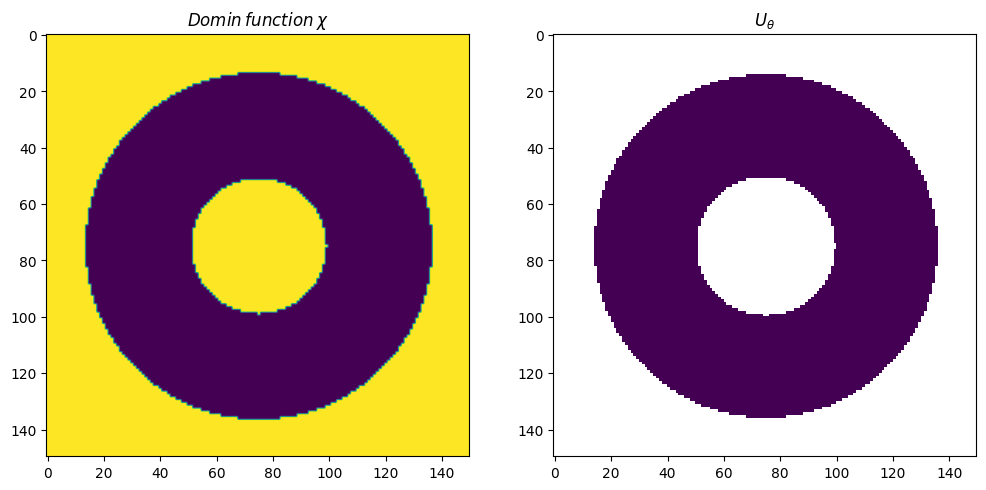

In [6]:
A  = ones(size(Ux));
χ = Array(GPUprob.params.χ);
A[χ.==1].=NaN;
figure(figsize=(12,6))
subplot(121);
imshow(χ[:,:,1]);
title(L"Domin\:function\:\chi");
subplot(122);
imshow((A.*Uθ)[:,:,1]);
title(L"U_\theta");

In [ ]:
# Set up the initial condition
@CUDA.time TimeIntegrator!(GPUprob, 300.0,500000;
                                   diags = [],
                             loop_number = 1000,
                                    save = false,
                                save_loc = "",
                                filename = "",
                                  dump_dt = 0)

n =     1000, t =     11.0, KE =     8.59, ME=    0.844
n =     2000, t =     21.9, KE =     12.0, ME=    0.844
n =     3000, t =     32.8, KE =     14.3, ME=    0.844
n =     4000, t =     43.8, KE =     15.6, ME=    0.844
n =     5000, t =     54.7, KE =     16.5, ME=    0.844
n =     6000, t =     65.6, KE =     16.9, ME=    0.844
n =     7000, t =     76.5, KE =     17.2, ME=    0.844
n =     8000, t =     87.4, KE =     17.4, ME=    0.844
n =     9000, t =     98.3, KE =     17.4, ME=    0.844
n =    10000, t =    109.0, KE =     17.5, ME=    0.844
n =    11000, t =    120.0, KE =     17.5, ME=    0.844
n =    12000, t =    131.0, KE =     17.5, ME=    0.844
n =    13000, t =    142.0, KE =     17.5, ME=    0.844
n =    14000, t =    153.0, KE =     17.5, ME=    0.844
n =    15000, t =    164.0, KE =     17.5, ME=    0.845
n =    16000, t =    175.0, KE =     17.4, ME=    0.858
n =    17000, t =    185.0, KE =     16.6, ME=    0.925
n =    18000, t =    196.0, KE =     15.0, ME=  

In [ ]:
iv,jv,kv = Array(GPUprob.vars.ux),Array(GPUprob.vars.uy),Array(GPUprob.vars.uz);
ib,jb,kb = Array(GPUprob.vars.bx),Array(GPUprob.vars.by),Array(GPUprob.vars.bz);
Ur,Uθ = xy_to_polar(iv,jv);

figure(figsize=(18,6))

subplot(131)
imshow((A.*kv)[div(N,2),:,:]',cmap="jet");colorbar();
title(L"U_z\:(r-z\:plane)",size=16)


subplot(132)
title(L"U_\theta\:(r-\theta\:plane)",size=16)
Uθ2D = (A .*Uθ)[:,:,30];
meanTA = mean(Uθ2D[.~isnan.(Uθ2D)]);
stdTA  =  std(Uθ2D[.~isnan.(Uθ2D)]);
imshow(Uθ2D,vmin=meanTA-2stdTA,vmax=meanTA+2stdTA,cmap="jet");colorbar()


subplot(133)
title(L"B_z\:(r-z\:plane)",size=16)
imshow((A.*kb)[:,div(N,2),:]',cmap="jet");colorbar();